In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

2022-11-26 15:21:14.753050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 15:21:15.350766: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-26 15:21:15.350815: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-11-26 15:21:15.350819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT librar

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import jax
import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax

import tensorflow_datasets as tfds

/home/pc3090/miniconda3/envs/jax/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(42)

In [4]:
num_classes = 10

In [5]:
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024, seed=42)
train_ds, test_ds = tfds.load('mnist:3.*.*', split=['train[:80%]', 'train[80%:]'])

def preprocess(x):
    image, label = x['image'], x['label']
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.reshape(image, (-1,))
    # label = 1 if label % 2 == 0 else 0
    label = int(label)
    return image, label

train_ds = train_ds.map(preprocess).as_numpy_iterator()
test_ds = test_ds.map(preprocess).as_numpy_iterator()

def load_x_y(ds):
    x_list, y_list = [], []
    for x, y in ds:
        x = x / np.linalg.norm(x)
        y = np.eye(num_classes)[y]
        x_list.append(x)
        y_list.append(y)
    return np.stack(x_list, axis=0), np.stack(y_list, axis=0)

train_x, train_y = load_x_y(train_ds)
test_x, test_y = load_x_y(test_ds)

In [6]:
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(48000, 784) (12000, 784) (48000, 10) (12000, 10)


In [7]:
_,_,kernel_fn = stax.serial(stax.Dense(1024), stax.Relu(), stax.Dense(1))
kernel_fn = jax.jit(kernel_fn, static_argnums=(2,))

In [8]:
train_length = 20000
test_length = 10000
inds = np.random.randint(0, train_x.shape[0], train_length)
train_x = train_x[inds]
train_y = train_y[inds]
inds = np.random.randint(0, test_x.shape[0], test_length)
test_x = test_x[inds]
test_y = test_y[inds]

test_x_copy = test_x.copy()

In [9]:
test_x.shape

(10000, 784)

In [10]:
all_x = np.concatenate([train_x, test_x], axis=0)
all_y = np.concatenate([train_y, test_y], axis=0)

In [11]:
K = kernel_fn(all_x, all_x, 'ntk')
K.shape

2022-11-26 15:21:26.739924: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:492] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(30000, 30000)

In [12]:
K_train = K[:train_length, :train_length]
K_test = K[:train_length, train_length:]

In [13]:
pred = K_test.T @ jnp.linalg.inv(K_train + train_length * 1e-8 * jnp.eye(K_train.shape[0])) @ train_y
pred = np.argmax(pred, axis=-1)
gt = np.argmax(test_y, axis=-1)
(pred == gt).mean()

DeviceArray(0.9694, dtype=float32)

In [14]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_x, train_y, diag_reg=train_length * 1e-8)
predict_fn = jax.jit(predict_fn)
pred = predict_fn(x_test=test_x).ntk
pred = np.argmax(pred, axis=-1)
gt = np.argmax(test_y, axis=-1)
(pred == gt).mean()

DeviceArray(0.9769, dtype=float32)

In [15]:
def predict(x_test):
    K_new = kernel_fn(train_x, x_test, 'ntk')
    return K_new.T @ jnp.linalg.inv(K_train + K_train.shape[0] * 1e-8 * jnp.eye(K_train.shape[0])) @ train_y

def loss_fn(test_x, test_y):
    pred = predict(x_test=test_x)
    loss = (0.5 * (pred - test_y) ** 2).mean()
    return loss

def evaluate(test_x, test_y):
    pred = predict(x_test=test_x)
    y_pred = jnp.argmax(pred, axis=-1)
    gt = jnp.argmax(test_y, axis=-1)
    accuracy = jnp.mean(y_pred == gt)
    return y_pred, accuracy

def update(test_x, test_y, epsilon=0.1, delta=0.3):
    grad = jax.grad(loss_fn)(test_x, test_y)
    grad = jnp.reshape(grad, test_x.shape)
    x_adv = test_x + epsilon * jnp.sign(grad)
    x_adv = jnp.clip(x_adv, a_min=test_x - delta, a_max=test_x + delta)
    return x_adv

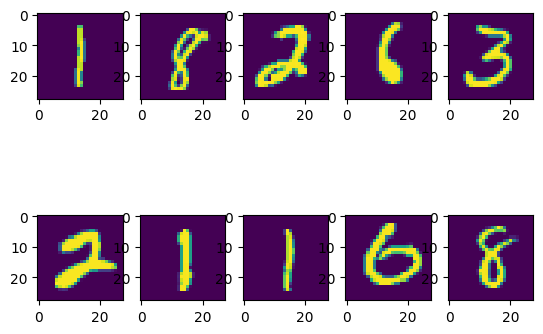

In [16]:
x = test_x_copy[:10]
cnt = 0
ncol, nrow = 5, 2
for i in range(ncol * nrow):
    cnt += 1
    plt.subplot(nrow, ncol, cnt)
    plt.imshow(x[i].reshape(28, 28, 1))
plt.show()

In [17]:
x = test_x_copy.copy()

pred, acc = evaluate(x, test_y)
before = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

num_iteration = 10

acc_list = list()
for step in tqdm(range(num_iteration)):
    x = update(x, test_y, epsilon=0.1, delta=2e-3)
    x = x / jnp.linalg.norm(x, axis=1)[:, None]
    _, acc = evaluate(x, test_y)
    acc_list.append(acc)

pred, acc = evaluate(x, test_y)
after = {'pred': jax.device_get(pred), 'acc': jax.device_get(acc)}

100%|██████████| 10/10 [00:42<00:00,  4.24s/it]


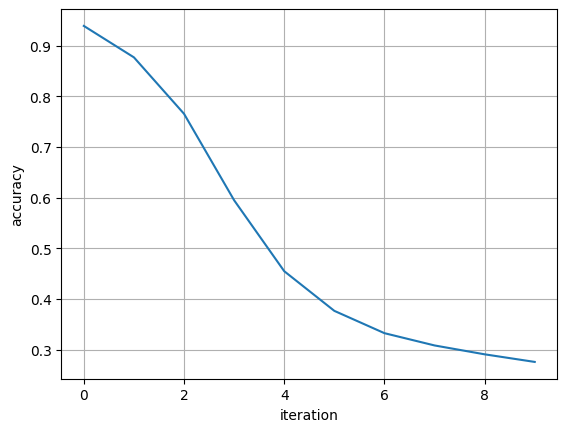

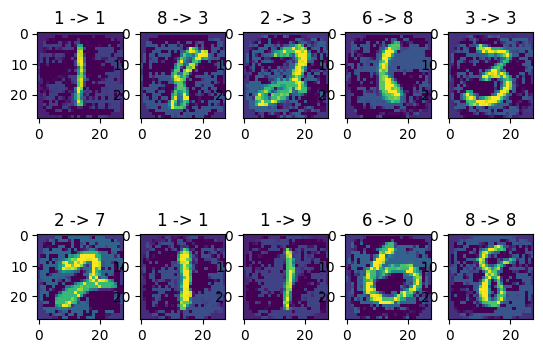

In [18]:
plt.plot(acc_list)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.grid()
plt.show()

cnt = 0
ncol, nrow = 5, 2
for i in range(ncol * nrow):
    cnt += 1
    before_pred = before['pred'][i]
    after_pred = after['pred'][i]
    plt.subplot(nrow, ncol, cnt)
    plt.title(f'{before_pred} -> {after_pred}')
    plt.imshow(x[i].reshape(28, 28, 1))
plt.show()

In [19]:
print(f'Accuracy: {before["acc"]} -> {after["acc"]}')

Accuracy: 0.9693999886512756 -> 0.2760999798774719
